# Direct sampling with Gaussian process regression

#### Import general modules

mpi4py is always required when using these tools. Numpy is always good to have if any manipulation is to be done.

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pynektools

In this case we will import all the data types that we currently support, as well as io functions that are required to populate them.

In [2]:
# Data types
from pynektools.datatypes.msh import Mesh
from pynektools.datatypes.coef import Coef
from pynektools.datatypes.field import Field, FieldRegistry

# Readers
from pynektools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pynektools.io.ppymech.neksuite import pwritenek, pynekwrite

fname = '../data/mixlay0.f00001'
#fname = '/home/adperez/Documents/gaussian_process/Gaussian Process_0823/data/turbPipe/turbPipe0.f00001'


## Read the data

In [3]:
msh = Mesh(comm, create_connectivity=False)
fld = FieldRegistry(comm)

pynekread(fname, comm, data_dtype=np.double, msh = msh, fld = fld)

for e in range(msh.nelv):
    if (np.min(msh.x[e]), np.max(msh.x[e])) == (0, 0.25):
        if (np.min(msh.y[e]), np.max(msh.y[e])) == (0, 1.1399999856948853):
            print(e)
    
coef = Coef(msh=msh, comm=comm)

2025-02-24 23:10:44,460 - Mesh - INFO - Initializing empty Mesh object.
2025-02-24 23:10:44,462 - Field - INFO - Initializing empty Field object
2025-02-24 23:10:44,462 - pynekread - INFO - Reading file: ../data/mixlay0.f00001
2025-02-24 23:10:44,467 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-24 23:10:44,468 - Mesh - INFO - Initializing common attributes.
2025-02-24 23:10:44,469 - Mesh - INFO - Getting vertices
2025-02-24 23:10:44,470 - Mesh - INFO - Getting edge centers
2025-02-24 23:10:44,473 - Mesh - INFO - Facet centers not available for 2D
2025-02-24 23:10:44,473 - Mesh - INFO - Mesh object initialized.
2025-02-24 23:10:44,474 - Mesh - INFO - Mesh data is of type: float64
2025-02-24 23:10:44,474 - Mesh - INFO - Elapsed time: 0.007578838s
2025-02-24 23:10:44,475 - pynekread - INFO - Reading field data
2025-02-24 23:10:44,478 - pynekread - INFO - File read
2025-02-24 23:10:44,479 - pynekread - INFO - Elapsed time: 0.016296146s
1466
2025-02-24 23:10:44,486 

## Compress the data with GPR

### Initialize the Direct sampler

In [26]:
from pynektools.compression.gpc_direct_sampling import DirectSampler

ds = DirectSampler(comm=comm, msh=msh)

ds_torch = DirectSampler(comm=comm, msh=msh, bckend='torch')


2025-02-24 23:16:42,946 - DirectSampler - INFO - Initializing the DirectSampler from a Mesh object
2025-02-24 23:16:42,949 - DirectSampler - INFO - Initializing the DirectSampler from a Mesh object


AssertionError: 

In [5]:
print(ds_torch.device)

cuda


### Sample the data

In [6]:
ds.log.tic()

# Select the options
n_samples = 48
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)

# Sample here
ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="svd", compression_method="fixed_bitrate", bitrate = bitrate, covariance_keep_modes=1)
#ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=100, compression_method="fixed_bitrate", bitrate = bitrate)

ds_torch.sample_field(field=fld.registry["u"], field_name="u", covariance_method="svd", compression_method="fixed_bitrate", bitrate = bitrate, covariance_keep_modes=16)
#ds_torch.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=100, compression_method="fixed_bitrate", bitrate = bitrate)

ds.log.toc()

2025-02-24 23:10:46,296 - DirectSampler - INFO - Sampling the field with options: covariance_method: {covariance_method}, compression_method: {compression_method}
2025-02-24 23:10:46,297 - DirectSampler - INFO - Estimating the covariance matrix
2025-02-24 23:10:46,298 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-24 23:10:46,300 - DirectSampler - INFO - Estimating the covariance matrix using the SVD method. Keeping 1 modes
2025-02-24 23:10:46,353 - DirectSampler - INFO - U saved in field uncompressed_data["u"]["U"]
2025-02-24 23:10:46,354 - DirectSampler - INFO - s saved in field uncompressed_data["u"]["s"]
2025-02-24 23:10:46,355 - DirectSampler - INFO - Vt saved in field uncompressed_data["u"]["Vt"]
2025-02-24 23:10:46,356 - DirectSampler - INFO - Sampling the field using the fixed bitrate method. using settings: {'method': 'fixed_bitrate', 'bitrate': np.float64(0.75), 'n_samples': 48}
2025-02-24 23:10:46,357 - DirectSampler - INFO - Proccesing up to 

In [7]:
print(ds_torch.uncompressed_data.keys())
#print(ds_torch.uncompressed_data["u"]['kw'])

dict_keys(['u'])


### Encode it

In [8]:
ds.compress_samples(lossless_compressor="bzip2")

ds_torch.compress_samples(lossless_compressor="bzip2")

print(ds.compressed_data["u"].keys())

2025-02-24 23:10:56,133 - DirectSampler - INFO - Compressing the data using the lossless compressor: bzip2
2025-02-24 23:10:56,134 - DirectSampler - INFO - Compressing data in uncompressed_data
2025-02-24 23:10:56,134 - DirectSampler - INFO - Compressing data for field ["u"]:
2025-02-24 23:10:56,134 - DirectSampler - INFO - Compressing ["U"] for field ["u"]
2025-02-24 23:10:56,137 - DirectSampler - INFO - Compressing ["s"] for field ["u"]
2025-02-24 23:10:56,137 - DirectSampler - INFO - Compressing ["Vt"] for field ["u"]
2025-02-24 23:10:56,138 - DirectSampler - INFO - Compressing ["field"] for field ["u"]
2025-02-24 23:10:56,174 - DirectSampler - INFO - Compressing the data using the lossless compressor: bzip2
2025-02-24 23:10:56,175 - DirectSampler - INFO - Compressing data in uncompressed_data
2025-02-24 23:10:56,175 - DirectSampler - INFO - Compressing data for field ["u"]:
2025-02-24 23:10:56,176 - DirectSampler - INFO - Compressing ["U"] for field ["u"]
2025-02-24 23:10:56,189 - 

### Write it out

In [9]:
ds.write_compressed_samples(comm=comm, filename="test")

ds_torch.write_compressed_samples(comm=comm, filename="test_torch")

2025-02-24 23:10:56,234 - DirectSampler - INFO - Parallel HDF5 not available; creating folder to store rank files.
2025-02-24 23:10:56,238 - DirectSampler - INFO - Parallel HDF5 not available; creating folder to store rank files.


In [10]:
print(ds_torch.settings)

{'dtype': 'double', 'mesh_information': {'lx': np.int64(8), 'ly': np.int64(8), 'lz': np.int64(1), 'nelv': np.int64(1600), 'gdim': 2}, 'covariance': {'method': 'svd', 'averages': np.int64(1600), 'elements_to_average': 1, 'keep_modes': 16, 'kw_diag': True}, 'compression': {'method': 'fixed_bitrate', 'bitrate': np.float64(0.75), 'n_samples': 48}}


In [11]:
print(ds.uncompressed_data["u"]["field"].shape)

#print(ds.uncompressed_data["u"]["kw"].shape)
#print(ds.uncompressed_data["u"]["U"].shape)
#print(ds.uncompressed_data["u"]["s"].shape)
#print(ds.uncompressed_data["u"]["Vt"].shape)

(1600, 1, 8, 8)


### Read the data in another object

In [12]:
ds_read = DirectSampler(comm, filename="test")
ds_torch_read = DirectSampler(comm, filename="test_torch")


2025-02-24 23:10:56,263 - DirectSampler - INFO - Initializing the DirectSampler from file: test
2025-02-24 23:10:56,287 - DirectSampler - INFO - Initializing the DirectSampler from file: test_torch


In [13]:
# Hack it a bit to make the rest work

ds.field = fld.registry["u"]
ds.field_sampled = ds.uncompressed_data["u"]["field"]
#ds.kw = ds.data_to_compress["u"]["kw"]

averages = ds.settings["covariance"]["averages"]
elements_to_average = ds.settings["covariance"]["elements_to_average"]

if ds.settings["covariance"]["method"] == "svd":
    # Retrieve the SVD components
    U = ds.uncompressed_data[f"u"]["U"]
    s = ds.uncompressed_data[f"u"]["s"]
    Vt = ds.uncompressed_data[f"u"]["Vt"]

    # Construct the f_hat
    f_hat = np.einsum("ik,k,kj->ij", U, s, Vt)

    # This is the way in which I calculate the covariance here and then get the diagonals
    if ds.kw_diag == True:
        # Get the covariances
        kw_ = np.einsum("eik,ekj->eij", f_hat.reshape(averages*elements_to_average,-1,1), f_hat.reshape(averages*elements_to_average,-1,1).transpose(0,2,1))
        # Extract only the diagonals
        kw_ = np.einsum("...ii->...i", kw_)
        
    else:
        # But I can leave the calculation of the covariance itself for later and store here the average of field_hat
        kw_ = f_hat.reshape(averages*elements_to_average,-1,1)

    ds.kw = kw_

else:
    ds.kw = ds.uncompressed_data[f"u"]["kw"]



print(ds.kw.shape)

ds.elements_to_average = ds.settings["covariance"]["elements_to_average"]
ds.n_samples = ds.settings["compression"]["n_samples"]

(1600, 64)


In [14]:
ind_50 = np.where(ds.field_sampled[0] == -50)
#print(ds.field[0])
#print(ds.field_sampled[0])
a = abs(ds.field_sampled[0])-abs(ds.field[0])
a[ind_50] = -50
print(a)

for e in range(msh.nelv):
    ind_50 = np.where(ds.field_sampled[e] == -50)
    if len(ind_50[0]) > n_samples:
        print(e, len(ind_50[0]))

[[[  0. -50.   0.   0.   0.   0.   0.   0.]
  [  0. -50. -50.   0.   0. -50.   0.   0.]
  [  0.   0.   0.   0.   0.   0. -50.   0.]
  [  0.   0.   0. -50.   0.   0. -50.   0.]
  [  0. -50.   0. -50.   0. -50.   0.   0.]
  [  0.   0.   0.   0. -50.   0. -50.   0.]
  [  0.   0. -50.   0.   0. -50. -50. -50.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]]]


In [15]:

print(ds.field_hat[1466].reshape(-1,1, order='F'))

print("======")

print(ds.field_sampled[1466].reshape(-1,1, order='F'))

[[ 1.99990441e-01]
 [-5.57531503e-06]
 [-1.80462288e-08]
 [ 7.00211732e-09]
 [-9.51879178e-09]
 [ 2.13566155e-09]
 [-5.95115817e-10]
 [-5.36121616e-10]
 [-8.59488645e-06]
 [-5.00078505e-06]
 [-3.83074439e-09]
 [ 8.52690949e-09]
 [-8.40598942e-09]
 [ 2.39046847e-09]
 [-8.58811016e-10]
 [-2.42388614e-10]
 [-2.37776126e-06]
 [-1.36844321e-06]
 [ 1.57842481e-08]
 [ 5.69112633e-09]
 [-2.72724125e-09]
 [ 4.27633113e-10]
 [-4.92429909e-10]
 [ 4.96550225e-10]
 [ 1.13080070e-07]
 [ 7.57060759e-08]
 [ 1.00539981e-08]
 [ 8.09318145e-10]
 [-2.86645941e-10]
 [ 2.32829433e-10]
 [ 1.42264199e-10]
 [ 4.43830162e-10]
 [ 8.43976818e-08]
 [ 4.96585829e-08]
 [-1.09479314e-09]
 [ 8.54305353e-10]
 [ 9.55948182e-10]
 [-8.39331422e-10]
 [ 3.69644683e-10]
 [ 2.50419075e-10]
 [-1.66313403e-08]
 [-1.06633414e-08]
 [-2.55425789e-09]
 [-9.41682210e-11]
 [ 1.41116511e-09]
 [-6.89430439e-10]
 [ 6.21008604e-11]
 [ 1.17915297e-09]
 [-4.47323203e-09]
 [-2.63863014e-09]
 [-1.17943747e-09]
 [-1.12387309e-09]
 [ 1.3693124

In [16]:
recon = ds.predict(ds.field_sampled)
recon3, _ = ds.reconstruct_field(field_name="u", get_mean=True)

recon2, recon2_std = ds_read.reconstruct_field(field_name="u", get_mean=True, get_std=True)

recon2_torch, recon2_std_torch = ds_torch_read.reconstruct_field(field_name="u", get_mean=True, get_std=True)

2025-02-24 23:10:56,906 - DirectSampler - INFO - Proccesing up to 256/1600 element
Done with covariance!
2025-02-24 23:10:56,948 - DirectSampler - INFO - Proccesing up to 512/1600 element
Done with covariance!
2025-02-24 23:10:56,987 - DirectSampler - INFO - Proccesing up to 768/1600 element
Done with covariance!
2025-02-24 23:10:57,025 - DirectSampler - INFO - Proccesing up to 1024/1600 element
Done with covariance!
2025-02-24 23:10:57,063 - DirectSampler - INFO - Proccesing up to 1280/1600 element
Done with covariance!
2025-02-24 23:10:57,102 - DirectSampler - INFO - Proccesing up to 1536/1600 element
Done with covariance!
2025-02-24 23:10:57,141 - DirectSampler - INFO - Proccesing up to 1600/1600 element
Done with covariance!
2025-02-24 23:10:57,155 - DirectSampler - INFO - Proccesing up to 256/1600 element
Done with covariance!
2025-02-24 23:10:57,214 - DirectSampler - INFO - Proccesing up to 512/1600 element
Done with covariance!
2025-02-24 23:10:57,280 - DirectSampler - INFO - Pr

In [17]:
print(np.all(ds.ind_train_sample == ds.ind_train_rct))
print(np.all(ds.ind_train_rct == ds_read.ind_train_rct))


diff = np.where(ds.ind_train_sample != ds.ind_train_rct)

for e in range(msh.nelv):
    if e in diff[0]:
        print(ds.ind_train_sample[e]
        , ds.ind_train_rct[e])

#for e in range(msh.nelv):
#    print(ds.ind_train_sample[e])

True
True


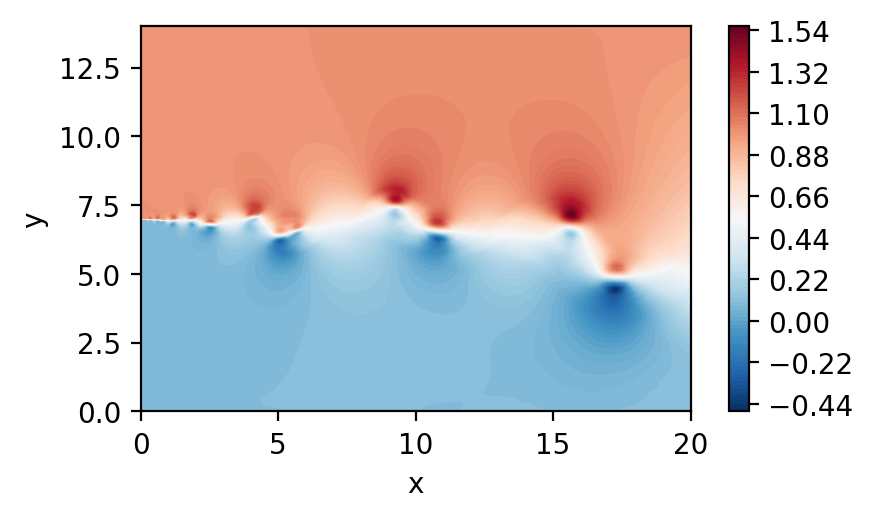

In [18]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_xlim([1.5,6.5])
#ax.set_ylim([5.5,8.5])
plt.show()

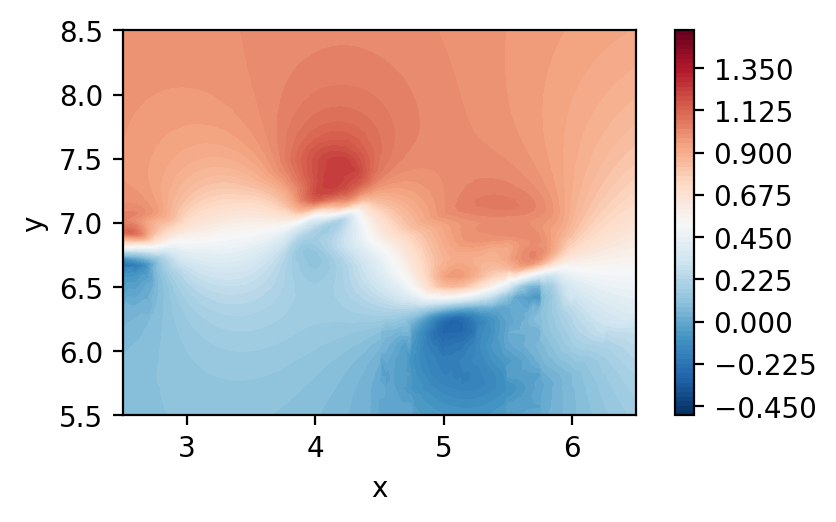

In [19]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
#c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , fld.registry["u"].flatten() - recon.flatten(), levels=100, cmap="RdBu_r")
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,recon.flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([2.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

In [20]:
print(np.mean(fld.registry["u"] - recon))
print(np.max(abs(fld.registry["u"] - recon)))
print(np.min(abs(fld.registry["u"] - recon)))

print("=========================================")

print(np.mean(fld.registry["u"] - recon3))
print(np.max(abs(fld.registry["u"] - recon3)))
print(np.min(abs(fld.registry["u"] - recon3)))

1.5300436595342926e-05
0.12568518959955832
0.0
1.5300436595342926e-05
0.12568518959955832
0.0


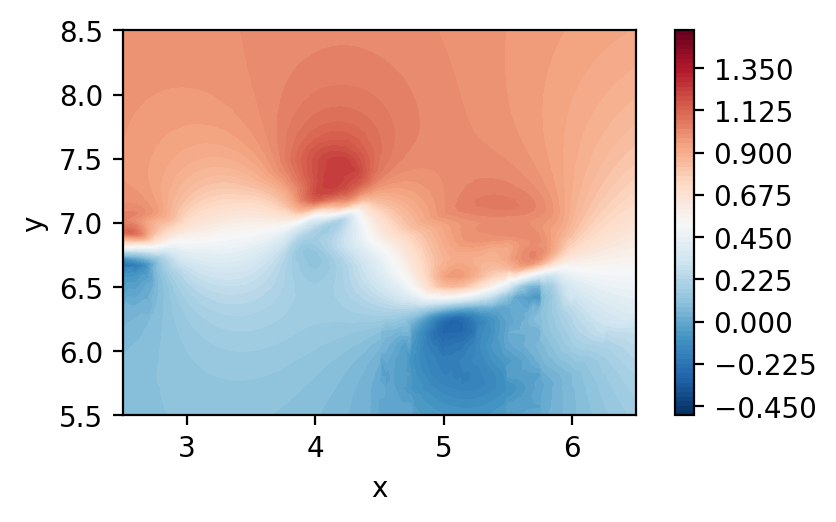

In [21]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
#c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , fld.registry["u"].flatten() - recon.flatten(), levels=100, cmap="RdBu_r")
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,recon2.flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([2.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

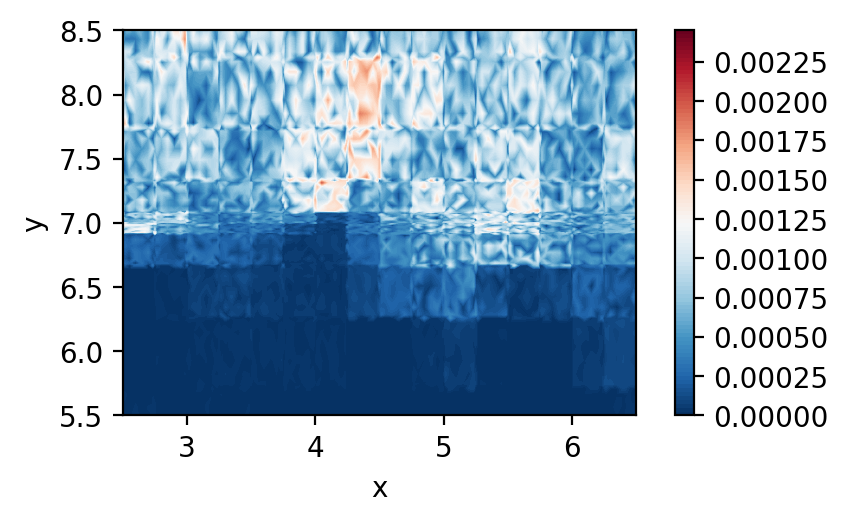

In [22]:

fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
#c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , fld.registry["u"].flatten() - recon.flatten(), levels=100, cmap="RdBu_r")
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,recon2_std.flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([2.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

In [23]:
print(np.mean(recon2 - recon))
print(np.max(abs(recon2 - recon)))
print(np.min(abs(recon2 - recon)))


print("=========================================")


print(np.mean(recon2_torch - recon))
print(np.max(abs(recon2_torch - recon)))
print(np.min(abs(recon2_torch - recon)))

0.0
0.0
0.0
1.3174924243156832e-05
0.12568518959955832
0.0


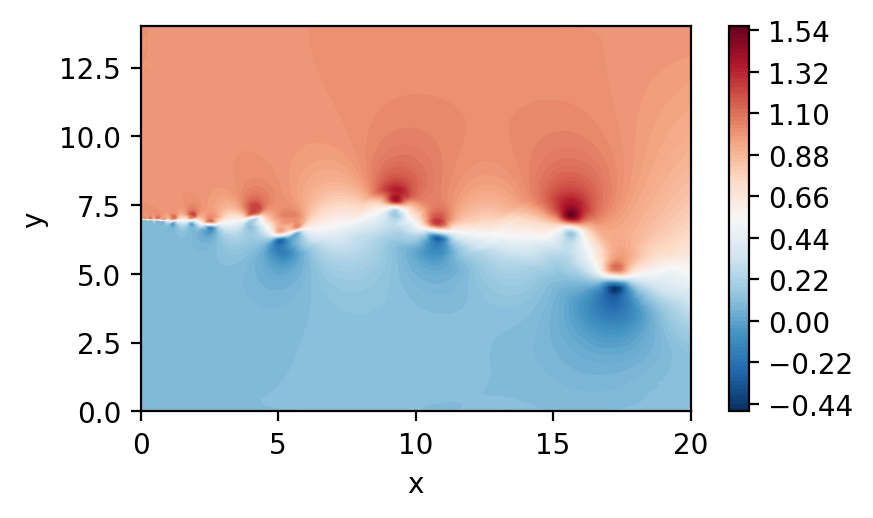

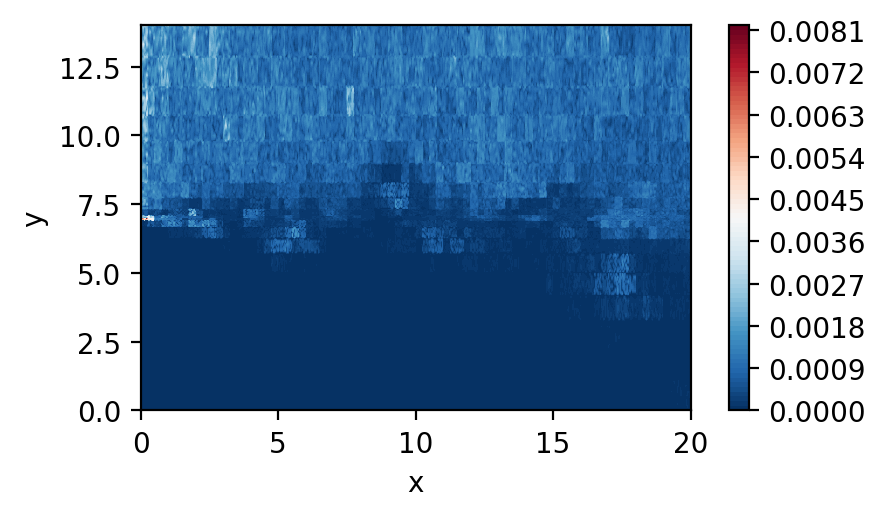

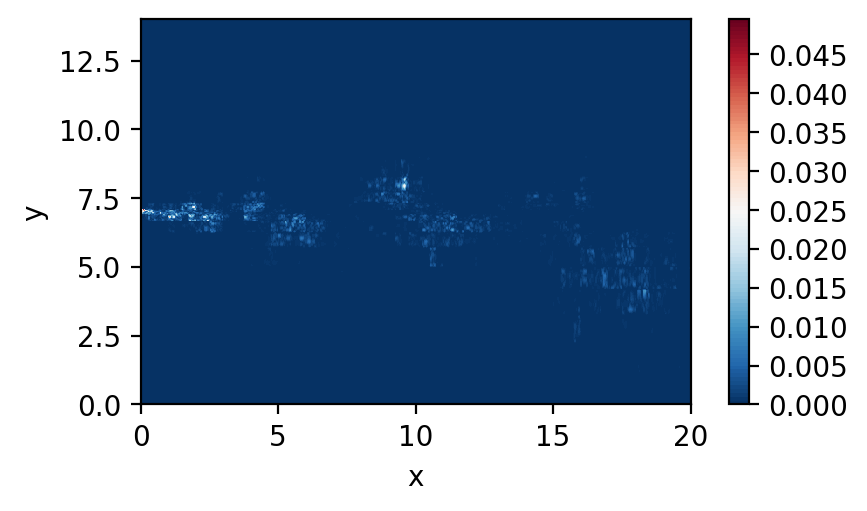

In [24]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
#c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , fld.registry["u"].flatten() - recon2_torch.flatten(), levels=100, cmap="RdBu_r")
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,recon2_torch.flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_xlim([1.5,6.5])
#ax.set_ylim([5.5,8.5])
plt.show()


fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
#c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , fld.registry["u"].flatten() - recon2_torch.flatten(), levels=100, cmap="RdBu_r")
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,recon2_std_torch.flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_xlim([1.5,6.5])
#ax.set_ylim([5.5,8.5])
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , np.sqrt((fld.registry["u"].flatten() - recon2_torch.flatten())**2), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_xlim([1.5,6.5])
#ax.set_ylim([5.5,8.5])
plt.show()

In [25]:
print(ds.indtrain.shape)

y = ds.field_sampled.reshape(ds.settings["covariance"]["averages"], ds.settings["covariance"]["elements_to_average"], ds.lx*ds.ly*ds.lz, -1)

indtrain2 = np.where(y != -50)
print(y[indtrain2[0], indtrain2[1], indtrain2[2], indtrain2[3]])
indtrain3 = np.zeros_like(ds.indtrain)
print(indtrain3.shape)


for e in range(ds.settings["covariance"]["averages"]):
    for i in range(ds.settings["covariance"]["elements_to_average"]):
        temp = np.where(y[e,i] != -50)
        indtrain3[e,i, :len(temp[0])] = temp[0]
indtrain3 = np.sort(indtrain3, axis=2)


for e in range(ds.settings["covariance"]["averages"]):
    for i in range(ds.settings["covariance"]["elements_to_average"]):
        i1 = ds.indtrain[e,i]
        i2 = indtrain3[e,i]
        if np.any(i1 != i2):
            print(e,i)
            print(i1)
            print(i2)

AttributeError: 'DirectSampler' object has no attribute 'indtrain'